<a href="https://colab.research.google.com/github/ArtemShuvalov/Econometrics/blob/main/Econometrics_HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Estimation of OLS, LASSO, RIDGE

Here is our linear model definition:
$$Y=X \beta + \epsilon $$
In order to get the OLS estimator we choose to minimize the Residual Sum of Squares (RSS), as we want to see how our predicted model matches the data. In order to avoid cancellation of the terms with different signs, we take square. Later, we will find out that according to the Gauss-Markov theorem the estimator $\hat{\beta}$ will be BLUE (Best Linear Unbiased Estimator).
$$RSS = (Y-X\beta)^T(Y-X\beta) = Y^TY - Y^TX\beta - \beta^TX^TY + \beta^TX^TX\beta → min_{\beta}$$

$$FOC: \dfrac{\partial RSS}{\partial \beta} = 0 - 2X^TY + 2X^TX\beta = \mathbb{0}$$
Therefore:
$$ \beta = (X^TX)^{-1}(X^TY)$$

When it comes to LASSO Regression, we want to penalize for the high values of coefficients and add the regularizer to our RSS. LASSO is L-1 regularization:
$$RSS_{LASSO} = (Y-X\beta)^T(Y-X\beta) + \lambda ||\beta||_1$$
As the derivative is not defined for the absolute value of parameter, we will try some numerical minimization of the RSS:
$$RSS_{LASSO} = (Y-X\beta)^T(Y-X\beta) + \lambda |\beta| → min_{\beta}$$

Now let's consider RIDGE case, which is L-2 regularization:
$$RSS_{RIDGE} = (Y-X\beta)^T(Y-X\beta) + \lambda ||\beta||_2$$
$$RSS_{RIDGE} = Y^TY - Y^TX\beta - \beta^TX^TY + \beta^TX^TX\beta + \lambda \beta^T \beta → min_{\beta}$$
$$RSS_{RIDGE} = Y^TY - Y^TX\beta - \beta^TX^TY + \beta^T(X^TX+\lambda I)\beta → min_{\beta}$$
$$FOC: \dfrac{\partial RSS}{\partial \beta}=0-2X^TY+2(X^TX\beta+\lambda I)=0$$
Therefore:
$$\beta_{RIDGE} = (X^TX + \lambda I)^{-1}X^TY$$


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn.linear_model import Ridge, Lasso
from scipy.optimize import minimize

In [ ]:
class OLS:
  '''
  Object used for the implementation of the OLS model.

  Methods:
    fit(self) - used to fit the regressors to regressand with OLS
    summary(self) - used to print the descriptive statistics

  '''

  def __init__(self, X, y, include_const, regularization=None, reg_hyperparam=None):
    '''
    Method for the initialization of the class

    Args:
      self - the initialization of the object
      X (np.array) - the features/regressor/explanatory variables of the model
      y (np.array) - the dependent variables/regressand of the model
      include_const (bool) - parameter to include contant or not
      regulariztion (str) - the type of regularization (None, Lasso, Ridge)
      reg_hyperparam (float) - the hyperparameter of regularization 


    Outputs:
      None
    '''

    self.X = X
    self.y = y
    self.include_const = include_const
    self.regularization = regularization
    self.reg_hyperparam = reg_hyperparam
  
  def fit(self):
    '''
    Method for the fitting of the OLS model to the data

    Args:
      self - the initialization of the object

    Outputs:
      self.beta (np.array) - the value of the coefficients of the fitted OLS
    '''

    # Getting the dimensions of the input matrix
    try:
      self.n, self.k = self.X.shape[0], self.X.shape[1]
    except IndexError:
      self.X = self.X.reshape(self.X.shape[0], 1)
      self.n, self.k = self.X.shape[0], self.X.shape[1]
    
    # Adding constant if needed
    if (self.include_const == True) and (np.all(self.X[:, 0] == 1) == False):
      ones = [1.0 for x in range(self.X.shape[0])]
      self.X = np.insert(self.X, 0, ones, axis=1)
    
    # Define function to get mse for numerical minimization
    self.coef = np.linalg.inv(self.X.T @ self.X)@(self.X.T @ self.y)

    def mse_func(coef):
      mse = (1./(2*self.n)) * (self.y - self.X @ coef).T @ (self.y - self.X @ coef) + np.sum(self.reg_hyperparam * np.abs(coef))
      return mse

    # Save title for plot
    self.title = 'OLS'

    # Fitting the model given the different regularizers
    if self.regularization == None:
      self.coef = np.linalg.inv(self.X.T @ self.X)@(self.X.T @ self.y)
    elif self.regularization == 'Lasso':
      self.coef = minimize(mse_func, np.ones(self.k+1))['x']
      self.title = self.regularization
    elif self.regularization == 'Ridge':
      self.coef = np.linalg.inv(self.X.T @ self.X + self.reg_hyperparam * np.eye(self.k+1))@(self.X.T @ self.y)
      self.title = self.regularization

    self.predict = self.X @ self.coef
    
    self.residuals = self.y - self.predict
    self.rss = self.residuals.T @ self.residuals
    self.mse_resid = self.rss / (self.X.shape[0]-self.X.shape[1])
    self.tss = (self.y - np.mean(self.y)).T @ (self.y - np.mean(self.y))
    self.ess = (np.mean(self.y) - self.predict).T @ (np.mean(self.y) - self.predict)
    self.r_squared = 1.0 - self.rss / self.tss
    self.r_squared_adj = 1 - (1 - self.r_squared) * (self.n - 1) / (self.n - self.k - 1)

    self.coef_covar = np.linalg.inv(self.X.T @ self.X) * (self.residuals.T @ self.residuals) / (self.n - self.k - 1)
    self.coef_std = [np.sqrt(self.coef_covar[i, i]) for i in range(self.coef.shape[0])]
    self.coef_t_stat = self.coef / self.coef_std

    return self.coef

  def summary(self):
    '''
    Method for displaying the descriptive statistics of the model

    Args:
      self - the initialization of the object

    Outputs:
      summary (pd.DataFrame) - DataFrame with descriptive statistics
    '''

    # Creating DataFrame for the fitted values
    summary = pd.DataFrame(index=[[f'x_{i}' for i in range(self.k+1)]], 
                           columns=['Coefficient'])
    summary.loc[:, 'Coefficient'] = self.coef.ravel()
    summary.loc[:, 'Std Errors'] = self.coef_std
    summary.loc[:, 't-stat'] = self.coef_t_stat
    summary.loc['MSE Residuals', 'Coefficient'] = self.mse_resid
    summary.loc['R^2', 'Coefficient'] = self.r_squared
    summary.loc['R^2 adj', 'Coefficient'] = self.r_squared_adj
    summary.fillna('', inplace=True)

    display(summary)
  
  def plot_regression(self):
    coef_round = np.round(self.coef, 4)

    plt.figure(figsize=(10, 5))
    plt.plot(self.y, '.', color='g')
    plt.plot(self.predict, color='b')
    plt.legend([f'{coef_round[0]}+{coef_round[1]} X + ...', 'y'])
    plt.title(f'Fitted {self.title} Regression')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()
    

In [ ]:
# Define input array with angles from 60 degree to 300 degree converted to radians
X = np.array([i * np.pi / 180 for i in np.linspace(60, 300, 100)])
y = np.sin(X) + np.random.normal(0, 1, X.shape[0])

# Generate polynomial of power 3
data = pd.DataFrame(np.column_stack([X,y]),columns=['X','y'])

for i in range(2, 5):  
    colname = f'X_{i}'      
    data[colname] = data['X']**i

X = np.array(data[[col for col in data.columns if 'X' in col]])

,Coefficient,Std Errors,t-stat
x_0,-7.614445,4.26456,-1.785517
x_1,13.650571,6.668284,2.047089
x_2,-7.215044,3.602009,-2.003061
x_3,1.475979,0.806903,1.82919
x_4,-0.105260,0.063982,-1.645152
MSE Residuals,0.950601,,
R^2,0.422766,,
R^2 adj,0.398462,,


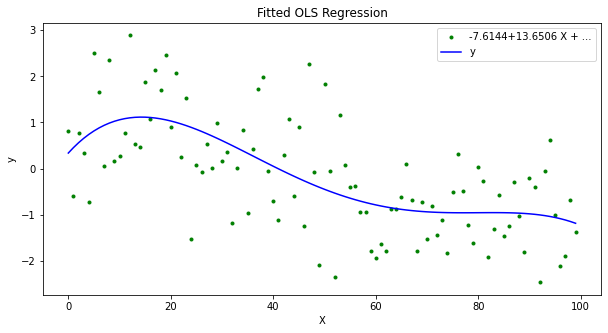

In [ ]:
# Standard OLS
ols = OLS(X, y, include_const=True)
beta = ols.fit()
ols.summary()
ols.plot_regression()

In [ ]:
# Let's compare with sklearn implementation
sm_ols = sm.OLS(y, add_constant(X)).fit()

print (sm_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     17.39
Date:                Sun, 17 Apr 2022   Prob (F-statistic):           9.73e-11
Time:                        10:17:29   Log-Likelihood:                -136.80
No. Observations:                 100   AIC:                             283.6
Df Residuals:                      95   BIC:                             296.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.6144      4.265     -1.786      0.0

,Coefficient,Std Errors,t-stat
x_0,0.471801,4.348523,0.108497
x_1,0.742989,6.799573,0.10927
x_2,-0.219019,3.672927,-0.059631
x_3,-0.079270,0.82279,-0.096344
x_4,0.016298,0.065242,0.249811
MSE Residuals,0.988401,,
R^2,0.399813,,
R^2 adj,0.374542,,


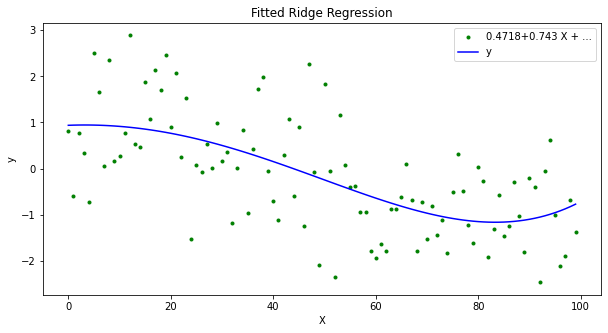

In [ ]:
# Ridge
alpha = 0.5
ols_ridge = OLS(X, y, include_const=True, regularization='Ridge', reg_hyperparam=alpha)
beta_ridge = ols_ridge.fit()
ols_ridge.summary()
ols_ridge.plot_regression()

In [ ]:
# Let's compare with sklearn implementation
sklearn_ridge = Ridge(alpha=alpha, fit_intercept=False)
sklearn_ridge.fit(sm.add_constant(X), y)

print (sklearn_ridge.coef_)
print(sklearn_ridge.score(sm.add_constant(X), y))

[ 0.47180118  0.74298911 -0.21901879 -0.07927045  0.01629802]
0.39981268879301024


,Coefficient,Std Errors,t-stat
x_0,-1.416202e-09,4.992917,-0.0
x_1,1.103956e-02,7.807181,0.001414
x_2,5.183538e-04,4.217207,0.000123
x_3,1.737797e-04,0.944716,0.000184
x_4,-2.225916e-03,0.074909,-0.029715
MSE Residuals,1.303042e+00,,
R^2,2.087532e-01,,
R^2 adj,1.754376e-01,,


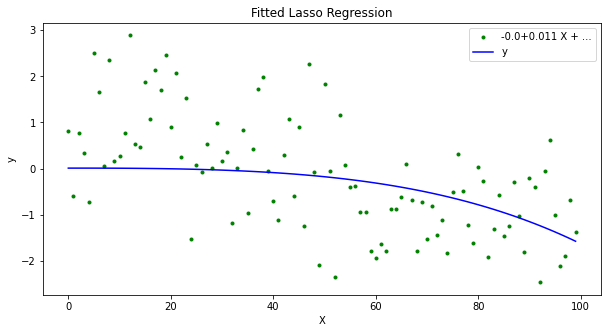

In [ ]:
# Lasso
ols_lasso = OLS(X, y, include_const=True, regularization='Lasso', reg_hyperparam=alpha)
beta_lasso = ols_lasso.fit()
ols_lasso.summary()
ols_lasso.plot_regression()

In [ ]:
# Let's compare with sklearn implementation
sklearn_lasso = Lasso(alpha=alpha, fit_intercept=False)
sklearn_lasso.fit(sm.add_constant(X), y)

print(sklearn_lasso.coef_)
print(sklearn_lasso.score(sm.add_constant(X), y))

[ 0.         0.         0.        -0.        -0.0020669]
0.20489975744640776


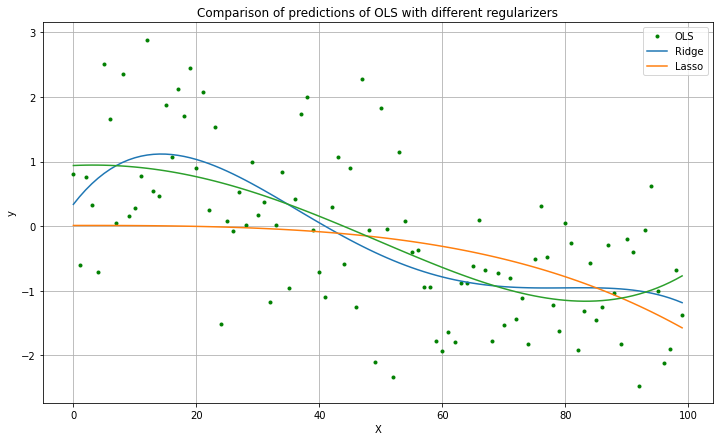

In [ ]:
# Common chart
plt.figure(figsize=(12, 7))
plt.plot(ols.y, '.', color='g')
plt.plot(ols.predict)
plt.plot(ols_lasso.predict)
plt.plot(ols_ridge.predict)
plt.legend(['OLS', 'Ridge', 'Lasso'])
plt.grid()
plt.title('Comparison of predictions of OLS with different regularizers')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [ ]:
# Check the distributions
N = [100, 1000, 100000, 1000000]
data_ols = {}
data_ridge = {}
data_lasso = {}

mse_ols = []
mse_ridge = []
mse_lasso = []

coef_std_ols = []
coef_std_ridge = []
coef_std_lasso = []

for i in range(0, len(N)):
    # Define input array with angles from 60 degree to 300 degree converted to radians
    X = np.array([i * np.pi / 180 for i in np.linspace(60, 300, N[i])])
    y_i = np.sin(X) + np.random.normal(0, 1, X.shape[0])

    # Generate polynomial of power 3
    data_i = pd.DataFrame(np.column_stack([X, y_i]),columns=['X','y'])

    for j in range(2, 4):  
        colname = f'X_{j}'      
        data_i[colname] = data_i['X']**j

    X = np.array(data_i[[col for col in data_i.columns if 'X' in col]])
    ols_i = OLS(X, y_i, include_const=True)
    beta_i = ols_i.fit()

    ols_ridge_i = OLS(X, y_i, regularization='Ridge', include_const=True, 
                      reg_hyperparam=alpha)
    beta_ridge_i = ols_ridge_i.fit()

    ols_lasso_i = OLS(X, y_i, regularization='Lasso', include_const=True, 
                      reg_hyperparam=alpha)
    beta_lasso_i = ols_lasso_i.fit()

    data_ols[N[i]] = beta_i
    mse_ols.append(ols_i.mse_resid)
    coef_std_ols.append(ols_i.coef_std)

    data_ridge[N[i]] = beta_ridge_i
    mse_ridge.append(ols_ridge_i.mse_resid)
    coef_std_ridge.append(ols_ridge_i.coef_std)
    
    data_lasso[N[i]] = beta_lasso_i                   
    mse_lasso.append(ols_lasso_i.mse_resid)
    coef_std_ridge.append(ols_lasso_i.coef_std)


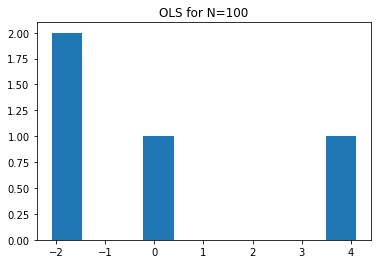

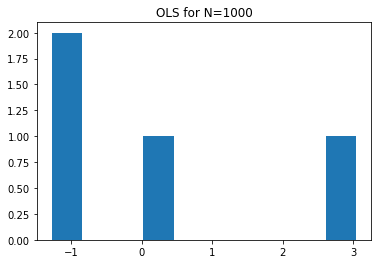

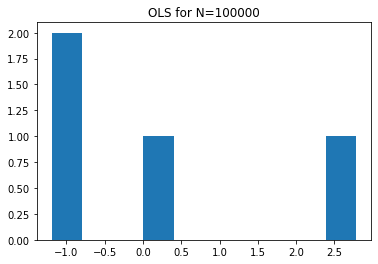

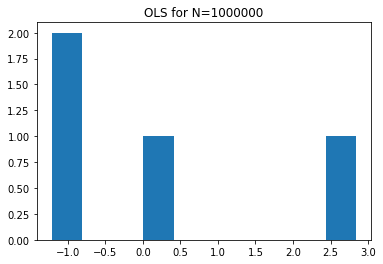

In [ ]:
for key in [key for key in data_ols.keys() if type(key) == int]:
  plt.figure()
  plt.hist(data_ols[key])
  plt.title(f'OLS for N={key}')

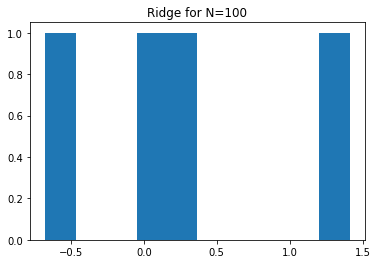

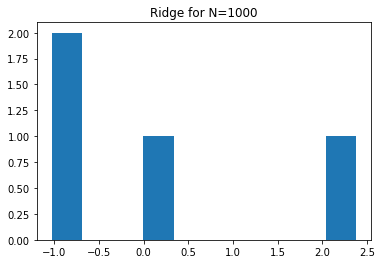

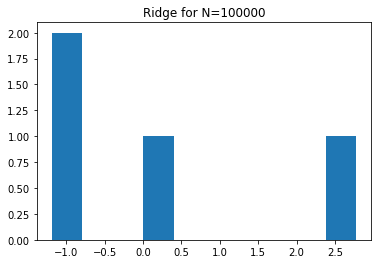

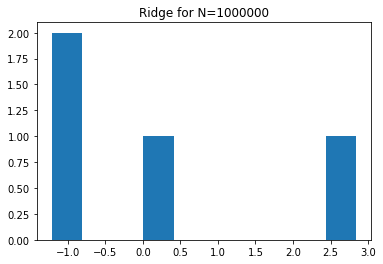

In [ ]:
for key in [key for key in data_ridge.keys() if type(key) == int]:
  plt.figure()
  plt.hist(data_ridge[key])
  plt.title(f'Ridge for N={key}')

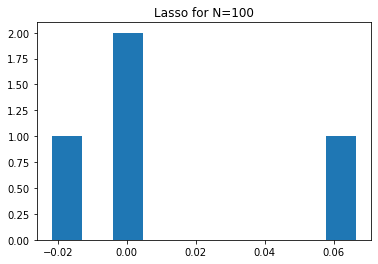

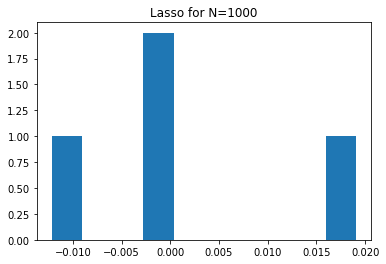

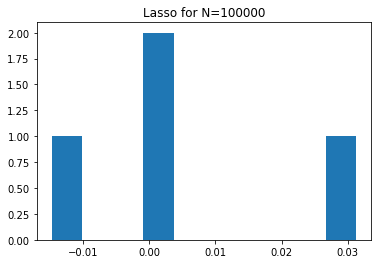

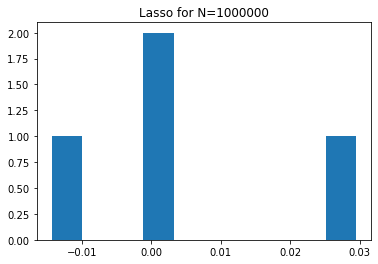

In [ ]:
for key in [key for key in data_lasso.keys() if type(key) == int]:
  plt.figure()
  plt.hist(data_lasso[key])
  plt.title(f'Lasso for N={key}')

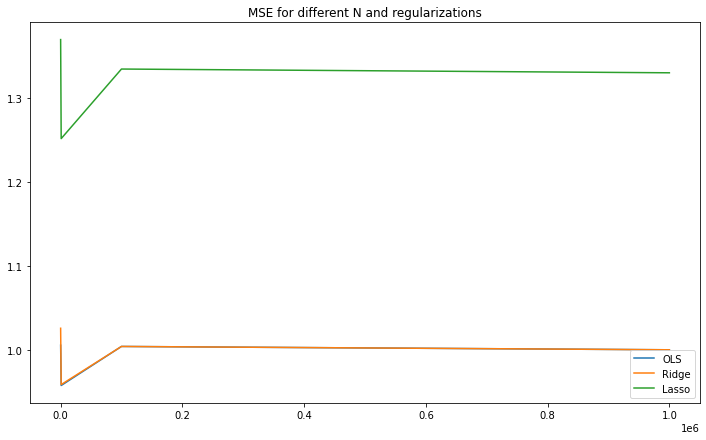

In [ ]:
plt.figure(figsize=(12, 7))
plt.title('MSE for different N and regularizations')
plt.plot(N, mse_ols)
plt.plot(N, mse_ridge)
plt.plot(N, mse_lasso)
plt.legend(['OLS', 'Ridge', 'Lasso'])
plt.show()